In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os 

from tqdm import tqdm_notebook

import cv2

In [4]:
path = "../data/stage_1_fixes/stage1_train/"
names = sorted(os.listdir(path))

In [217]:
path = "../data/1_stage_test/"
names = sorted(os.listdir(path))

In [5]:
train_names = names[:620]
val_names = names[620:]

In [7]:
DEFAULT_VERTICAL = 512

In [216]:
def process_data(names, prefix = '', use_padding = False, resize = False, store = False):
    im_w_mask_list = []
    
    for name in tqdm_notebook(names):
        im = plt.imread(path + name + "/images/" + name + ".png")[:,:,:3]

        resize_ratio = DEFAULT_VERTICAL / im.shape[0]

        mask = np.zeros_like(im[:,:,0])
#         masks_path = path + name + "/masks/"
#         masks_names = os.listdir(masks_path)

        
#         for m_name in masks_names:
#             mask += plt.imread(masks_path + m_name)

        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        
        if resize:
            im = cv2.resize(im, (DEFAULT_VERTICAL, int(im.shape[1] * resize_ratio)))
            mask = cv2.resize(mask, (DEFAULT_VERTICAL, int(mask.shape[1] * resize_ratio)))
        
        if use_padding:
            im,mask = mirror(im, mask)
        
        boarder = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, np.ones((2,2)))
        im_w_mask = (np.stack((im, mask, boarder), 2))
        
        
        #print(im_w_mask.shape)
        #np.save("../data/stage_1_processed/" + prefix + "/" + prefix + "_" + name, im_w_mask)
        
        if store:
            im_w_mask_list.append(im_w_mask)
        #masks.append(mask)
        
    
    return im_w_mask_list


In [218]:
im_w_mask_list_test = process_data(names[:], prefix='val', store=True)

A Jupyter Widget

In [10]:
def show(im, i = None, figsize =None):
    if len(im.shape) == 3:
        to_show = im[:,:,i]
    else:
        to_show = im
        
    if not figsize is None:
        plt.figure(figsize=(figsize))
    plt.imshow(to_show, cmap='gray')
    plt.show()
    

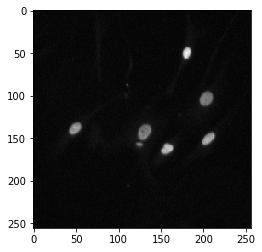

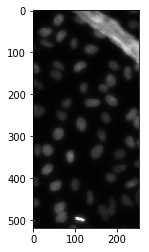

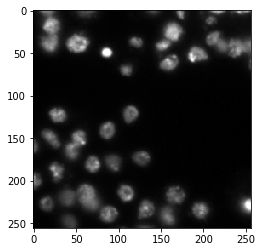

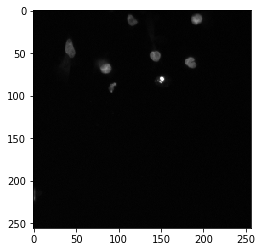

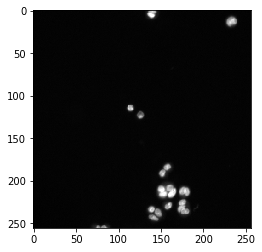

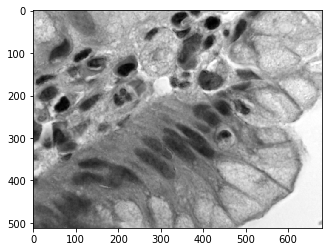

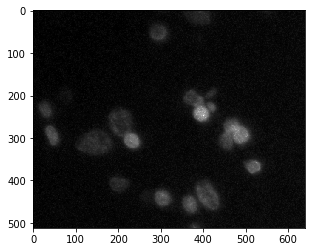

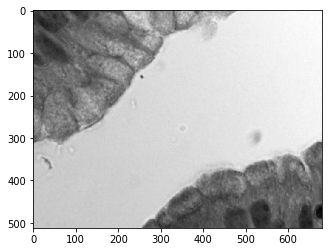

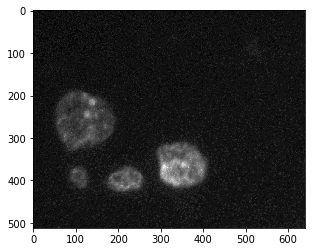

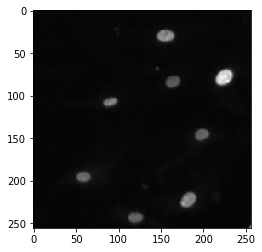

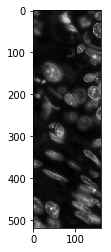

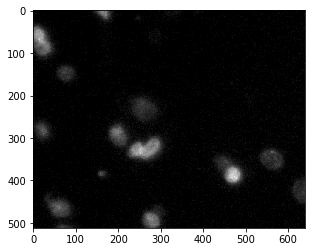

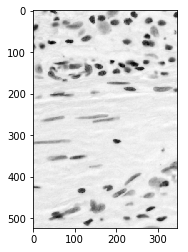

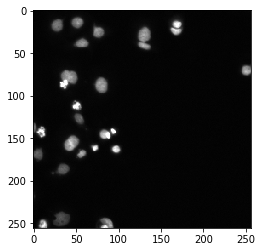

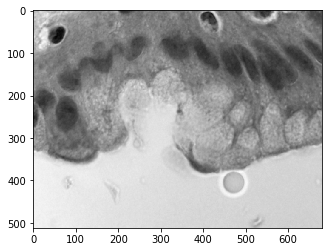

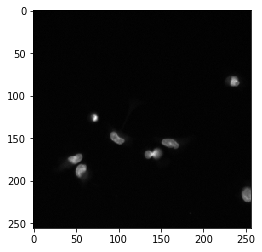

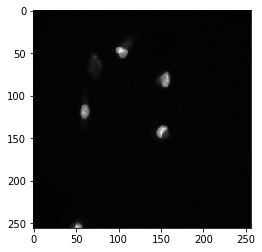

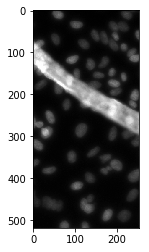

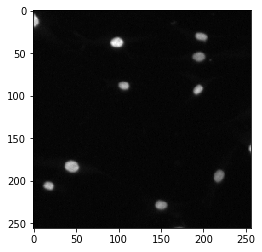

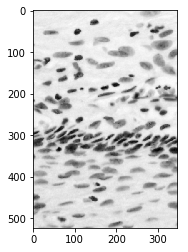

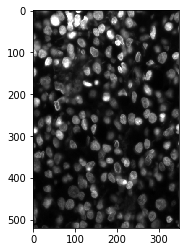

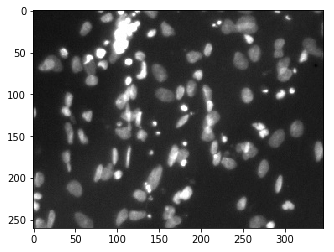

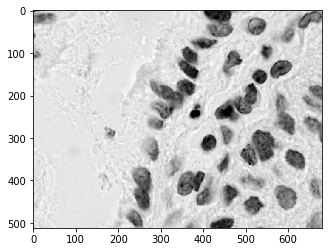

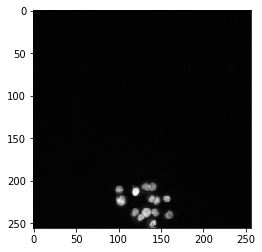

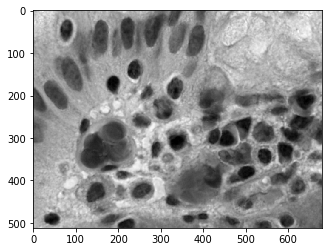

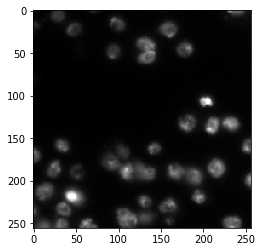

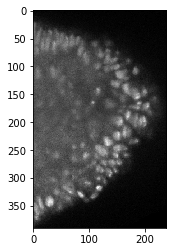

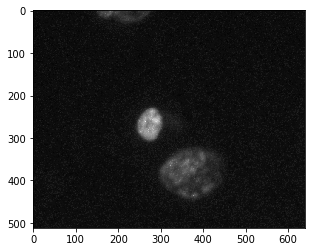

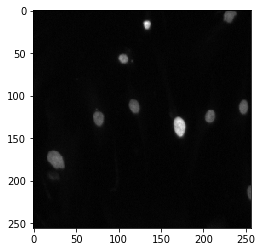

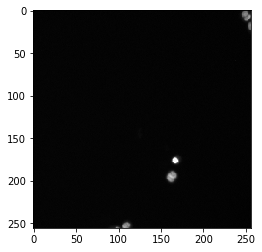

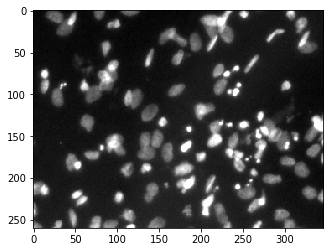

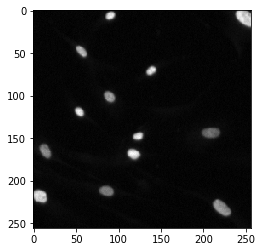

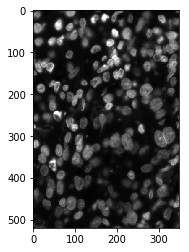

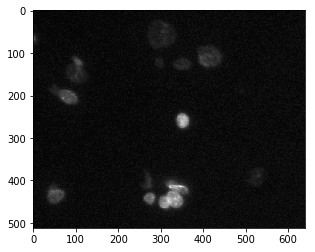

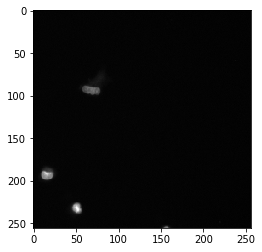

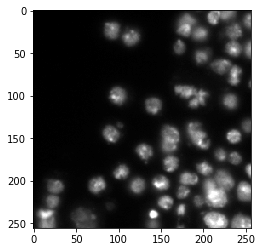

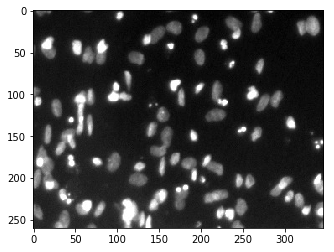

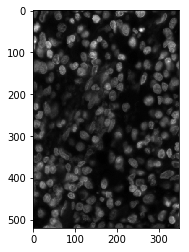

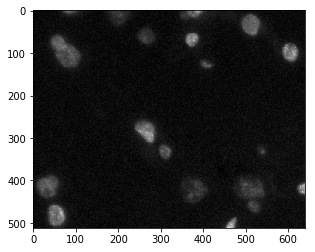

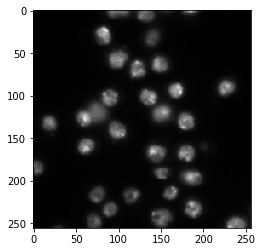

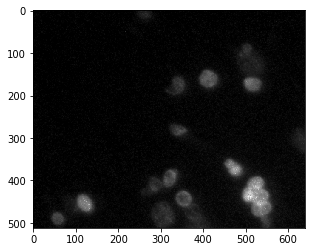

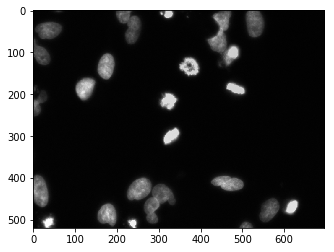

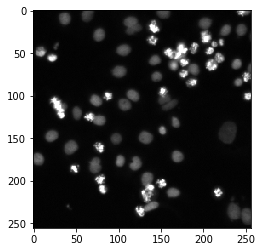

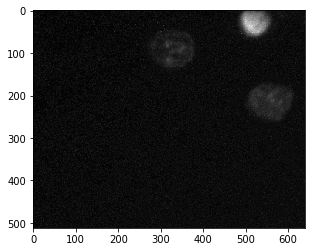

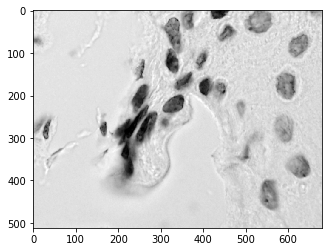

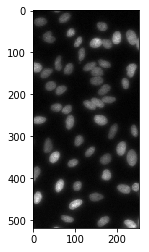

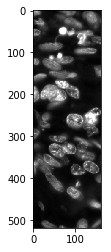

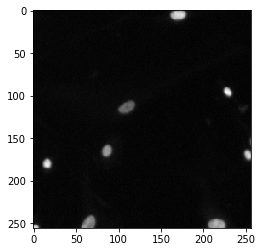

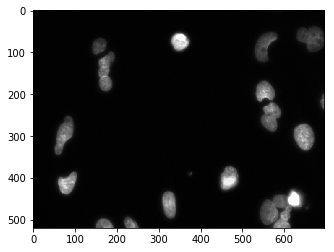

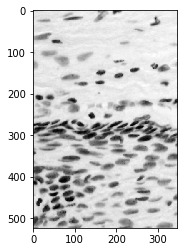

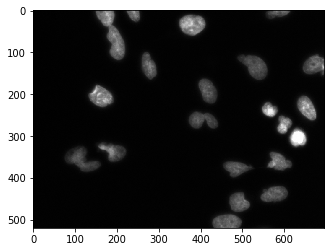

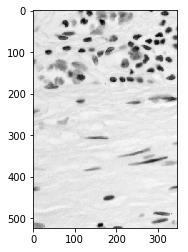

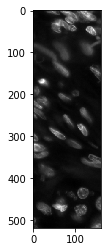

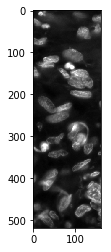

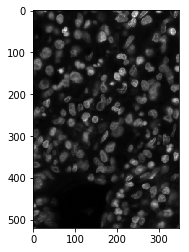

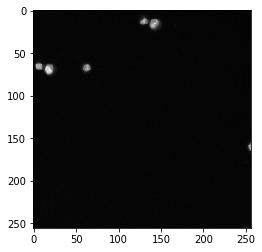

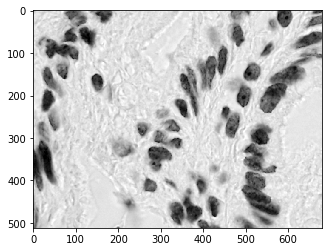

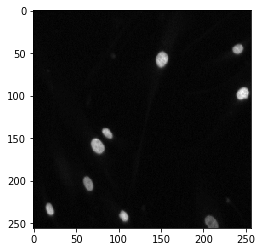

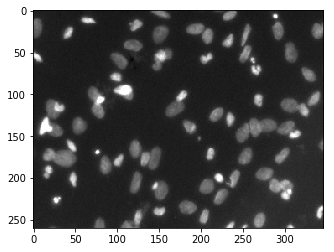

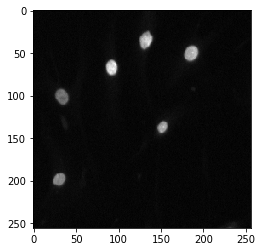

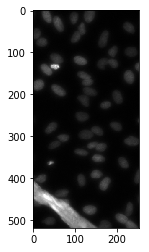

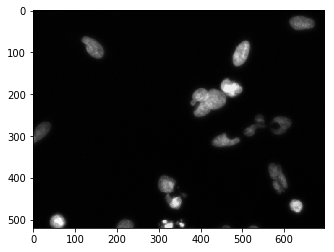

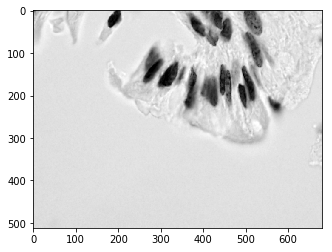

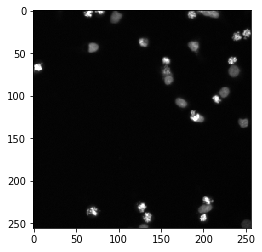

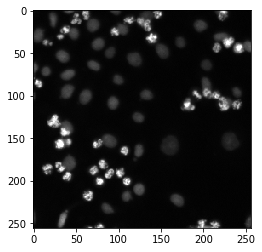

In [219]:
for im in im_w_mask_list_test[:]:
    show(im,0)

In [13]:
stats = np.concatenate(([np.array([np.std(im[:,:,0]),np.mean(im[:,:,0])]).reshape(1,-1) for im in im_w_mask_list]))

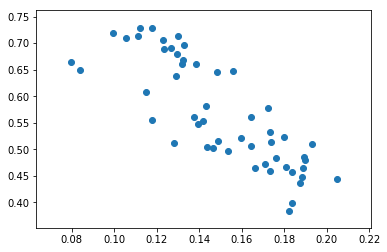

In [63]:
plt.scatter(stats[mask,0], stats[mask,1]**2)
plt.show()

In [44]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
km = KMeans(3)
db = DBSCAN()

In [135]:
g_m = GaussianMixture(3)

In [136]:
g_m.fit(stats)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [137]:
labels = g_m.predict(stats)

In [213]:
mask = labels == 2

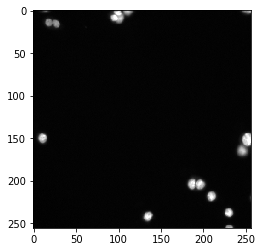

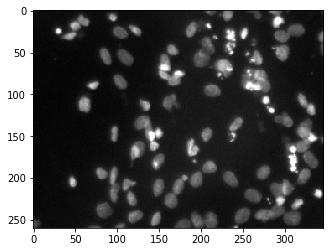

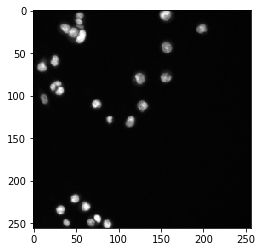

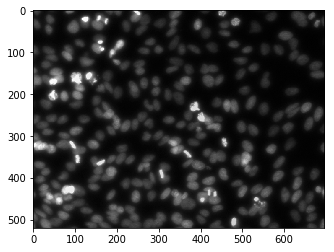

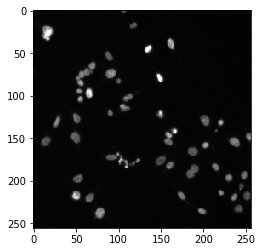

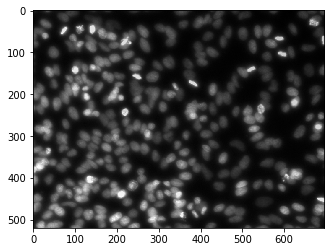

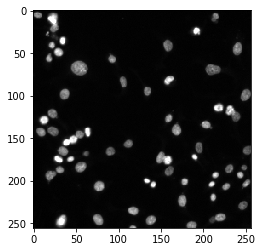

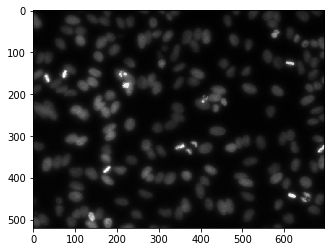

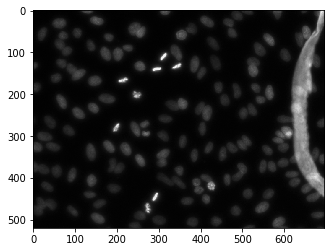

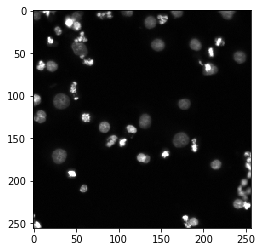

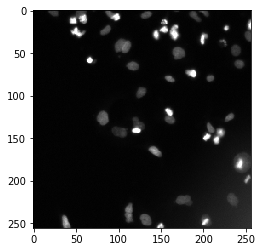

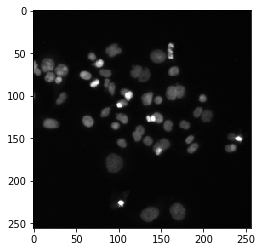

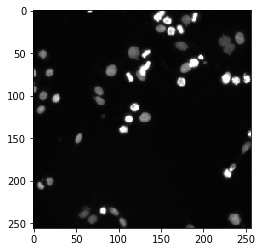

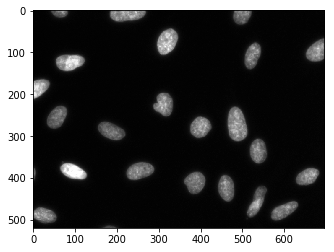

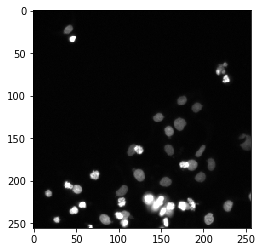

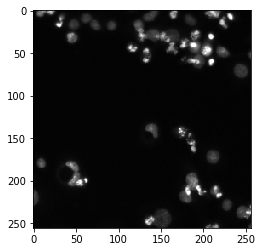

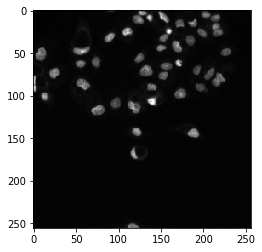

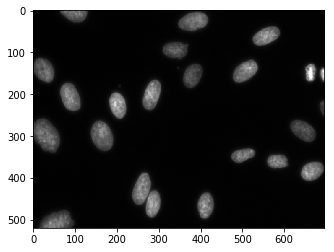

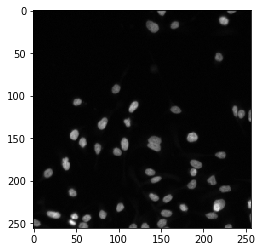

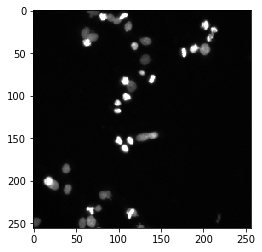

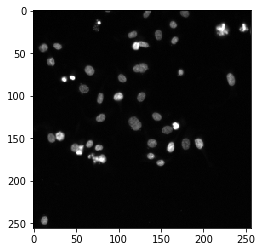

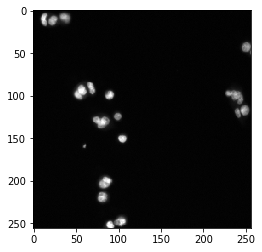

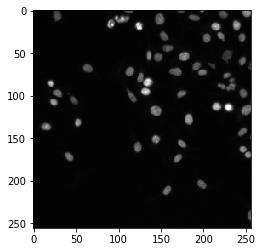

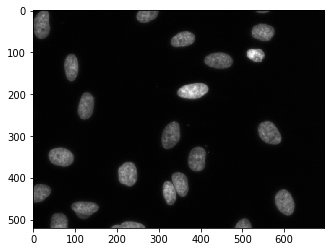

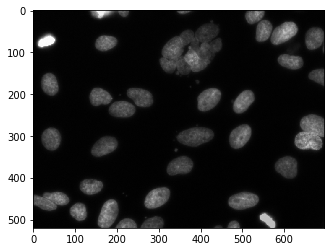

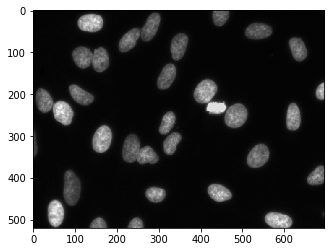

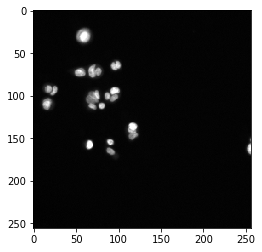

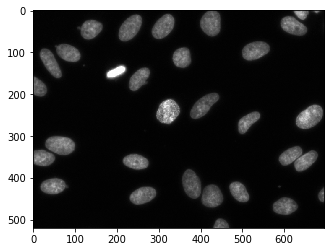

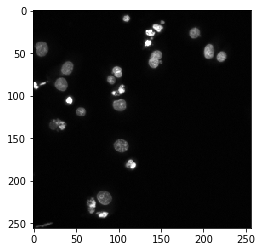

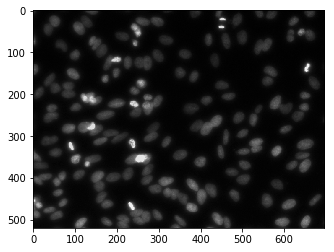

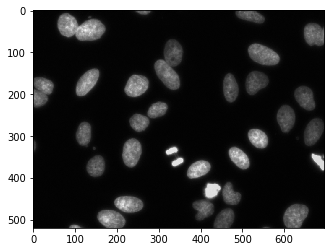

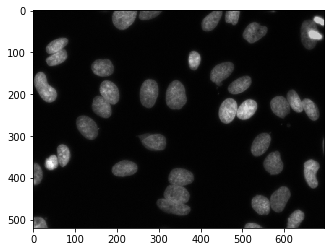

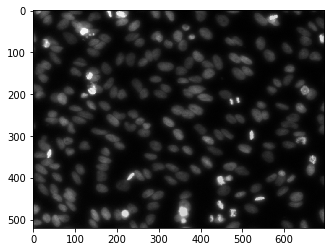

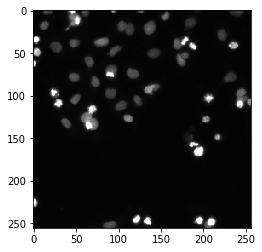

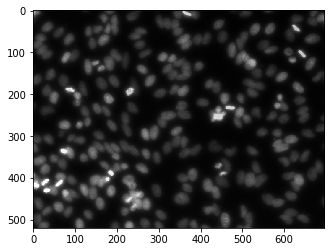

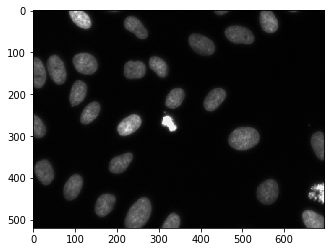

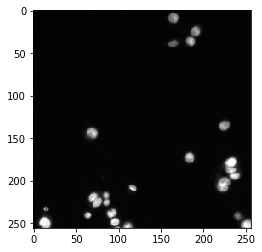

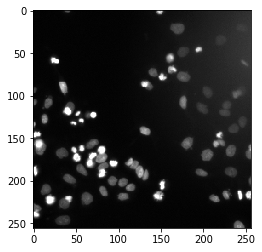

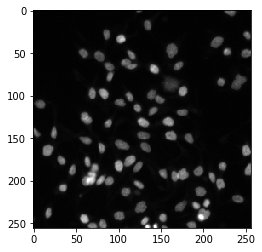

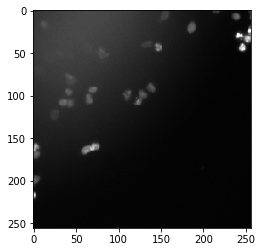

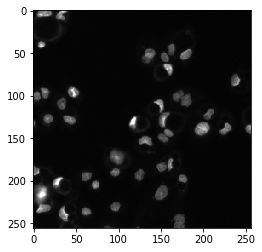

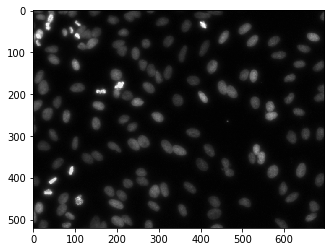

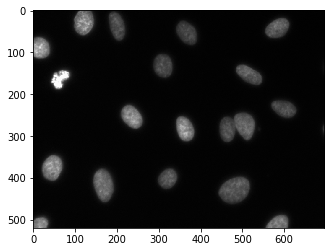

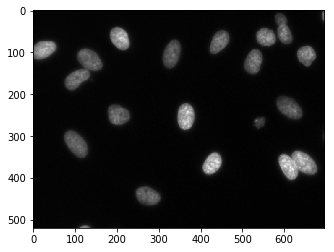

KeyboardInterrupt: 

In [214]:
for im in np.array(im_w_mask_list)[mask][:]:
    show(im,0)

In [155]:
np.where(labels == 2)

(array([  8,  11,  15,  21,  26,  42,  47,  55,  62,  72,  93,  99, 112,
        125, 129, 131, 135, 141, 145, 146, 152, 158, 163, 179, 181, 182,
        197, 202, 205, 208, 210, 213, 224, 230, 243, 249, 258, 275, 276,
        282, 286, 288, 298, 339, 354, 362, 365, 371, 380, 390, 399, 400,
        406, 415, 431, 456, 469, 478, 498, 501, 502, 508, 514, 520, 524,
        528, 546, 564, 565, 575, 577, 578, 583, 602, 613, 615, 617, 618]),)

In [215]:
names[11]

'0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd'

## WATERSHED

In [188]:
def podkladka(name, class_val):
    im = cv2.imread('../data/stage_1_train/' + name + "/images/" + name + ".png")
    
    print(im.shape)
    default = True
    if class_val == 1 and im.shape[0] > 1000:
        default = False
      
    return (process(im, default) > 0).astype(int)
    

In [208]:
ind = 25
img = cv2.imread('../data/stage_1_train/' + names[ind] + "/images/" +names[ind] + ".png")


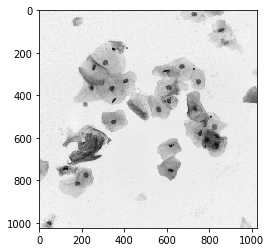

In [210]:
show(img, 0)

(1024, 1024, 3)


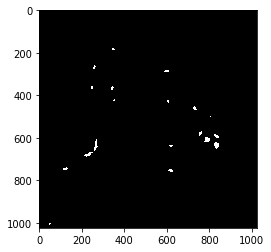

In [207]:
show(podkladka(names[ind], labels[ind]))

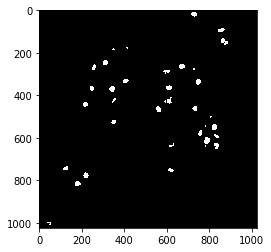

In [203]:
show(im_w_mask_list[ind],1)

In [72]:
import skimage.exposure

In [206]:
def process(img_rgb, scenario):
    #green channel happends to produce slightly better results
    #than the grayscale image and other channels
    #img_rgb = skimage.exposure.adjust_gamma(img_rgb, 0.5)
#     plt.imshow(process(img_rgb))
#     plt.show()
    
    img_gray=cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    #img_gray = img_rgb
    
    #morphological opening (size tuned on training data)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img_open=cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, circle7)
    #Otsu thresholding
    
    if scenario:
        img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    else:
        img_th=cv2.threshold(img_open,90,255,cv2.THRESH_BINARY)[1]
    
    #Invert the image in case the objects of interest are in the dark side
    if(np.sum(img_th==255)>np.sum(img_th==0)):
        img_th=cv2.bitwise_not(img_th)
    #second morphological opening (on binary image this time)
    bin_open=cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7) 
    #connected components
    cc=cv2.connectedComponents(bin_open)[1]
    #cc=segment_on_dt(bin_open,20)
    return cc

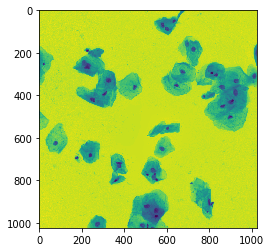

In [107]:
plt.imshow(rgb)
plt.show()

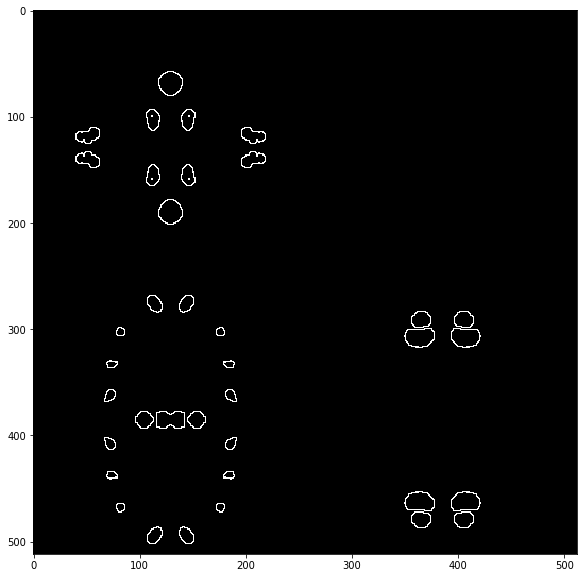

In [110]:
#plt.imshow(train_ims[1], cmap='gray')
#plt.show()
plt.figure(figsize=(10,10))
im = cv2.morphologyEx(train_masks[1], cv2.MORPH_GRADIENT, np.ones((2,2)))
plt.imshow(im, cmap='gray')
plt.show()

In [35]:
del train_masks

In [ ]:
min_horizontal = min([x.shape[1] for x in train_ims])
min_horizontal

In [ ]:
train_ims = [x[:,]]

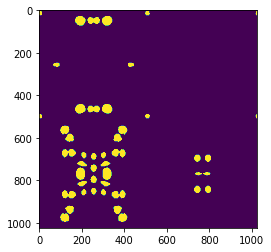

In [123]:
plt.imshow(miror(mask,mask)[0])
plt.show()

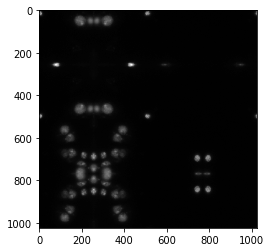

In [124]:
plt.imshow(miror(im,mask)[0], cmap='gray')
plt.show()

## 

In [5]:
shapes = np.zeros((670,3))

for i in range(len(names)):
    im = plt.imread(path + names[i] + "/images/" + names[i] + ".png")
    shapes[i] = im.shape

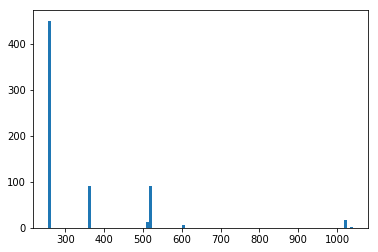

In [6]:
plt.hist(shapes[:,0], bins = 100)
plt.show()

In [22]:
set(shapes[:,0])

{256.0, 260.0, 360.0, 512.0, 520.0, 603.0, 1024.0, 1040.0}

In [19]:
set(shapes[:,1])

{256.0, 320.0, 347.0, 360.0, 640.0, 696.0, 1024.0, 1272.0, 1388.0}

In [38]:
np.where(shapes[:,0] == 1024)

(array([  3,  84,  96, 116, 119, 130, 209, 379, 386, 396, 415, 507, 515,
        617, 666, 667]),)

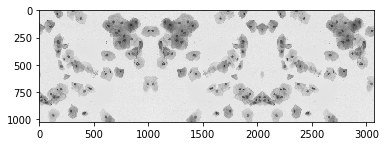

In [39]:
n = 3
im = plt.imread(path + names[n] + "/images/" + names[n] + ".png")
plt.imshow(np.hstack((im[:,::-1,:], im, im[:,::-1,:])))
plt.show()

In [40]:
im.shape

(1024, 1024, 4)

In [13]:
def random_select(im, mask, shape = (256, 256)):
    x = np.random.randint(0, im.shape[0] - shape[0])
    y = np.random.randint(0, im.shape[1] - shape[1])
    
    excerpt_x = slice(x, x+shape[0])
    excerpt_y = slice(y, y+shape[1])
    
    return im[excerpt_x, excerpt_y, :], mask[excerpt_x, excerpt_y, :]

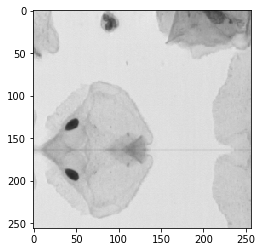

In [14]:

plt.imshow(random_select(miror(im, im)[0], miror(im, im)[0])[0])
plt.show()

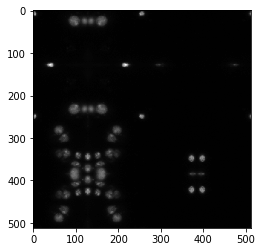

In [24]:
im = train_ims[0]
plt.imshow(im, cmap='gray')
plt.show()

In [15]:
import Augmentor as au

In [17]:
p = au.Pipeline()#.(miror(im, im)[0])

p.rotate(1, 25, 25)
p.flip_random(1)
p.random_distortion(1, 10,10,8)
p.skew(1)
p.

In [33]:
np.expand_dims(np.expand_dims(im, 0),3).shape

(1, 512, 512, 1)

In [79]:
im_w_mask = np.stack((train_ims[0], train_masks[0]), 2)
g = p.keras_generator_from_array((np.expand_dims(im_w_mask, 0)*255).astype('uint8'),np.ones(1), 1, )

In [78]:
#gens = [p.keras_generator_from_array(np.expand_dims(im, 0)*255).astype('uint8'),np.ones(1), for im in train_ims]

SyntaxError: invalid syntax (<ipython-input-78-5394cedf5a4b>, line 1)

In [ ]:
cv2.

In [90]:
n = next(g)

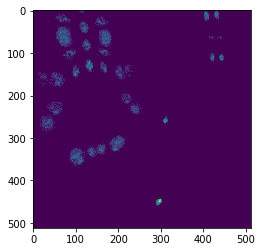

In [91]:
#augm_im = next(g)[0]
plt.imshow(n[0][0][:,:,0])
plt.show()

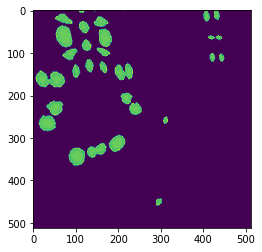

In [92]:
plt.imshow(n[0][0][:,:,1])
plt.show()

In [135]:
augm_im.shape

(1, 3072, 3072, 4)

In [77]:
np.expand_dims(miror(im, im)[0], 0).shape

(1, 3072, 3072, 4)

## ANSW

In [1]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

In [7]:
a = np.zeros((4,4))
a[0,1],a[1,1], a[1,2], a[2,1] = 1,1,1,1
a

array([[0., 1., 0., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.]])

In [8]:
rle_encoding(a)

[5, 3, 10, 1]

In [17]:
b = np.vstack((a,a))

In [10]:
[x for x in prob_to_rles(np.vstack((a,a)))]

[[9, 3, 18, 1], [13, 3, 22, 1]]